# Requirements

In [1]:
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import random

# Problem setting

The Kaprekar constant is computed using an iterative process that starts from an arbitrary four-digit number that consists of at least two distict digits.  Two new numbers are constructed that consist of the same digits, but sorted in descending order for the first, and in descending order for the second.  The smallest of these numbers is substracted from the largest to procuce a new number.  This procedure is repeated until the number no longer changes.

# Auxillary functions

We need functions to convert a number to a list of digits, and vice versa.

In [2]:
def num2digits(n):
    digits = []
    for _ in range(4):
        digits.append(n % 10)
        n //= 10
    return digits

In [3]:
def digits2num(digits):
    n = 0
    for i, digit in enumerate(digits):
        n += digit*10**i
    return n

We will also need a function to verify that a number has at least two distinct digits.

In [4]:
def is_valid_number(n):
    return len(set(f'{n:04d}')) > 1

To test, we convert a number to its list of digits, and back again.  If the result is the original number, the test succeeds.

In [5]:
for _ in range(1_000):
    n = random.randint(1000, 9999)
    assert(n == digits2num(num2digits(n)))

# Computing the constant

We define a function to perform a single step in this computation.

In [6]:
def kaprekar_step(n):
    digits = num2digits(n)
    high_number = digits2num(sorted(digits, reverse=False))
    low_number = digits2num(sorted(digits, reverse=True))
    return high_number - low_number

For example:

In [7]:
kaprekar_step(1049)

9261

Now we can define a function that will iterate until a fixed point is reached, or that will raise an exception when a maximum number of steps has been exceeded.

In [8]:
def kaprekar_sequence(n, max_steps=100):
    sequence = []
    previous_n = -1
    while n != previous_n:
        if len(sequence) > max_steps:
            raise RuntimeError('too many iterations')
        sequence.append(n)
        previous_n = n
        n = kaprekar_step(n)
    return sequence

In [9]:
kaprekar_sequence(4934)

[4934, 5994, 5355, 1998, 8082, 8532, 6174]

In [10]:
kaprekar_sequence(6174)

[6174]

# Step distribution

We now define a function that will compute the distribution of the number of steps required for all integers in the domain of the function, so for $1000 \le n \le 9999$ such that $n$ has at least two distict digits.

In [11]:
def compute_kaprekar_step_distribution():
    steps = Counter()
    for n in range(1_000, 10_000):
        if is_valid_number(n):
            nr_steps = 0
            while n != 6174:
                nr_steps += 1
                n = kaprekar_step(n)
            steps[nr_steps] += 1
    return steps

In [12]:
step_distribution = compute_kaprekar_step_distribution()

We can visualize the distribution in a histogram.

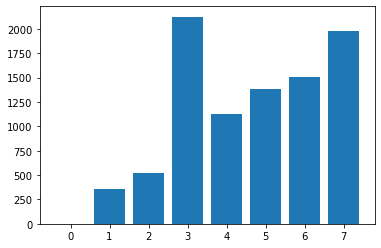

In [13]:
_ = plt.bar(step_distribution.keys(), step_distribution.values())

When considering this distributoin, it is clear that if we have compute the sequence of steps for numbers that take, e.g., 7 steps, we have implicitly computed the number of steps required for other numbers as well.  If we cache the result, we may be able to speed up the computation.

In [14]:
def compute_kaprekar_steps():
    steps = {}
    for n in range(1_000, 10_000):
        if is_valid_number(n):
            orig_n = n
            nr_steps = 0
            while n != 6_174:
                n = kaprekar_step(n)
                nr_steps += 1
            steps[orig_n] = nr_steps
    return steps

In [15]:
def compute_kaprekar_steps_cached():
    steps = {}
    for n in range(1_000, 10_000):
        if is_valid_number(n):
            orig_n = n
            nr_steps = 0
            while n != 6_174:
                if n in steps:
                    steps[orig_n] = nr_steps + steps[n]
                    break
                else:
                    n = kaprekar_step(n)
                    nr_steps += 1
            else:
                steps[orig_n] = nr_steps
    return steps

In [16]:
%timeit steps_cached = compute_kaprekar_steps_cached()

52 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [17]:
%timeit steps = compute_kaprekar_steps()

95.5 ms ± 374 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Checking the correctness of the implementation by comparing the results.

In [18]:
steps_cached = compute_kaprekar_steps_cached()
steps = compute_kaprekar_steps()

for n in steps:
    if n >= 1_000:
        assert(steps[n] == steps_cached[n])
for n in steps_cached:
    if n >= 1_000:
        assert(steps[n] == steps_cached[n])

Indeed, caching reduces the compute time by almost a factor of two.

# Recursive implementation

If we create a recursive function to compute the number of steps, we can use the LRU-cache in Python's standard libray.

In [19]:
def kaprekar_steps_recursive(n):
    if n == 6_174:
        return 0
    elif not is_valid_number(n):
        return 1
    else:
        n = kaprekar_step(n)
        return 1 + kaprekar_steps_recursive(n)

First verify the function works correectly.

In [20]:
for n, nr_steps in steps.items():
    assert(nr_steps == kaprekar_steps_recursive(n))

In [21]:
%timeit for n in range(1_000, 10_000): kaprekar_steps_recursive(n)

113 ms ± 421 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
from functools import lru_cache

In [23]:
@lru_cache
def kaprekar_steps_recursive_cached(n):
    if n == 6_174:
        return 0
    elif not is_valid_number(n):
        return 1
    else:
        n = kaprekar_step(n)
        return 1 + kaprekar_steps_recursive_cached(n)

In [24]:
%timeit for n in range(1_000, 10_000): kaprekar_steps_recursive_cached(n)

27.7 ms ± 177 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Using the LRU-cache significantly speeds up the code.

For comparison the iterative implementation.

In [25]:
def kaprekar_steps_iterative(n):
    if is_valid_number(n):
        nr_steps = 0
        while n != 6174:
            nr_steps += 1
            n = kaprekar_step(n)
        return nr_steps
    else:
        return 1

In [27]:
%timeit for n in range(1_000, 10_000): kaprekar_steps_iterative(n)

96.4 ms ± 239 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
